This is a guide on how to use the modified discrete Fourier transform (MDFT) to directly acquire the storage and loss behavior of a viscoelastic material from its stress (force) and strain (indentation) data.  This is mostly meant for FD curves from AFM experiments but can also be used for other devices that acquire similar stress-strain data.

First, import the required packages from the mdft.py file included in this folder.  We will also need numpy, pandas, and matplotlib to load, manipulate, and visualize the data.

In [1]:
from mdft import mdft, get_r, qmax, fitq

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

Here is a helpful function for visualizing the relaxance once we are done.  For now, don't worry about it.

In [28]:
def plot_re_im(q, w, fit=None):
    plt.plot(w, np.real(q), label='Data')
    if fit is not None:
        plt.plot(w, np.real(fit), label='Fit')
        plt.legend()
    plt.xlabel('Freq. (Hz)')
    plt.ylabel('Q\' (Pa)')
    plt.title('Storage Modulus')
    plt.grid()
    plt.show()
    plt.plot(w, np.imag(q), label='Data')
    if fit is not None:
        plt.plot(w, np.imag(fit), label='Fit')
        plt.legend()
    plt.xlabel('Freq. (Hz)')
    plt.ylabel('Q\" (Pa)')
    plt.title('Loss Modulus')
    plt.grid()
    plt.show()

Let's load the FD curves and see what they look like.

In [2]:
fds = [pd.read_excel(os.path.join('data', f), engine='openpyxl') for f in os.listdir('data') if 'xlsx' in f]

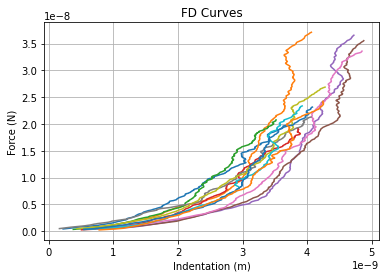

In [3]:
for fd in fds:
    plt.plot(fd.h.values, fd.f.values)
plt.grid()
plt.xlabel('Indentation (m)')
plt.ylabel('Force (N)')
plt.title('FD Curves')
plt.show()

Before we go further, we should define the necessary terms for the contact mechanics.  Specifically, we define the tip radius, the sampling frequency, the contact mechanics 'area' term, and the contact mechanics exponential term.  Refer to the supporting information for clarification.

In [4]:
R = 5 * 1e-6  # radius (m)
freq = 20e3  # sampling frequency (Hz)
a = 4 * np.sqrt(R) / (3 * (1 - 0.5 ** 2))  # 'area' term
b = 3 / 2  # exponential term

Let's now find the r values needed to bind each of our inputs.  Since we want to bind all of our inputs, we should select the largest of these r values.

In [5]:
r0 = max(max(get_r(a * abs(fd.h.values) ** (3 / 2)), get_r(fd.f.values)) for fd in fds)
r0

1.0081046132333165

To calculate the relaxance of the material, we recommend first taking the MDFT of each force and indentation individually and then averaging the spectra.  Once done, the averaged force and indentation spectra can be divided to obtain the relaxance.  To do this, it is important to also consider that each spectra must be the same number of points.  Therefore, we first figure out the length of the smallest curve in our list and use that number as our N point limit for the MDFT.  Let's see how this looks using the r value (r0) that we calculated above.

In [6]:
n = min(fd.f.size for fd in fds)
n

533

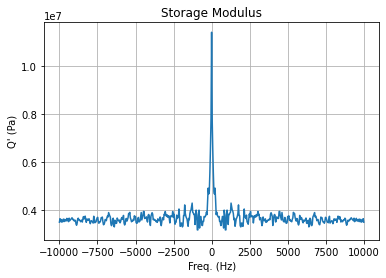

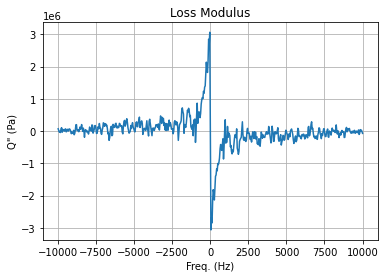

In [14]:
hz_mean = np.mean([mdft(a * abs(fd.h.values) ** (3 / 2), r0, n) for fd in fds], axis=0)
fz_mean = np.mean([mdft(fd.f.values, r0, n) for fd in fds], axis=0)
qz = fz_mean / hz_mean
# the frequency range that qz is defined over is from -pi to +pi radians or -nyquist frequency to +nyquist frequency Hz
w = np.linspace(-1, 1, qz.size) * freq / 2  
plot_re_im(qz, w)

Something is wrong!  The loss modulus should not be negative.  Also, the storage modulus does not follow a shape predicted by any linear theory.  We are close to a pole in the Z-domain which is causing a numerical error.  Let's try to move further away from it by increasing r slightly.

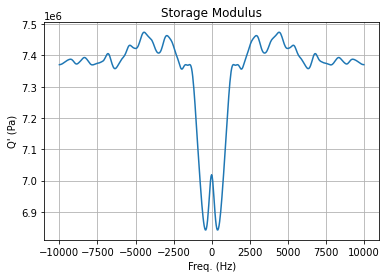

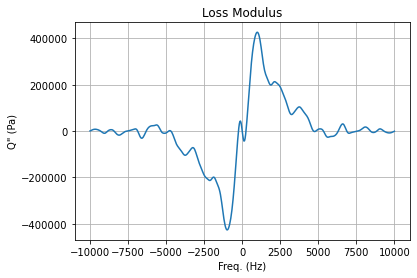

In [29]:
r_new = r0 * 1.1
hz_mean = np.mean([mdft(a * abs(fd.h.values) ** (3 / 2), r_new, n) for fd in fds], axis=0)
fz_mean = np.mean([mdft(fd.f.values, r_new, n) for fd in fds], axis=0)
qz = fz_mean / hz_mean
# the frequency range that qz is defined over is from -pi to +pi radians or -nyquist frequency to +nyquist frequency Hz
w = np.linspace(-1, 1, qz.size) * freq / 2  
plot_re_im(qz, w)

This looks much better!  Let's try to fit a Standard Linear Solid model to the data and see what parameters describe the material.  We perform the fitting by calling the fitq() function.  The first argument is the observed relaxance, q, the second argument is our decay constant, r, the third is the frequency domain of the observed relaxance, the fourth is the model we will fit qmax (aka 1 arm maxwell aka standard linear solid). There are a few other options included in the mdft.py script: qsp (springpot) and qplr (power law rheology).  One could alternatively define any desired model for the relaxance of a material.  As long as this function is in the form of func_name(X, r, freq) where X is an array of model parameters, r is the decay constant, and freq is the frequency domain, any model could be used with the fitq() function.

The fifth argument of the fitq() function is the initial guess for our model parameters [Ge, G1, Tau1], the sixth and seventh arguments contain the lower and upper bounds for the parameters.  We think it is best to let these be as wide as reasonably possible to prevent 'forcing' any physics into existence.

In [30]:
X = fitq(qz, r_new, w, qmax, [1, 1, 1], [0, 0, 0], [1e9, 1e9, 100])
print('Ge: {:.1f} MPa, G1: {:.1f} MPa, Tau1: {:.1f}s'.format(X[0] * 1e-6, X[1] * 1e-6, X[2]))

Ge: 6.4 MPa, G1: 1.1 MPa, Tau1: 6.3s


Let's take a look at our fit plotted against the data.  We can use the parameters from the fit_1() function to calculate the model's (qmax) relaxance.

In [32]:
q_fit_z = qmax(X, r_new, w)

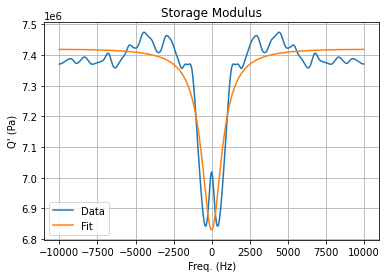

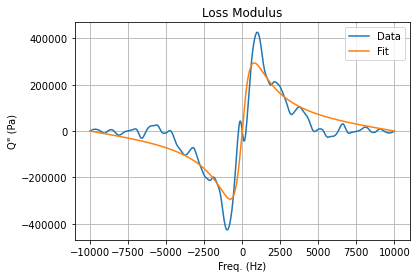

In [33]:
plot_re_im(qz, w, fit=q_fit_z)

The fit looks pretty good!  While useful for obtaining parameterized descriptions of materials, fitting in the Z-domain also allows for us to approximate the true storage and loss moduli.  Up until now, we have been working in the modified Fourier domain by using the decay constant set to ~1.1.  The Fourier domain behavior would be obtained by working with a decay constant of exactly 1; however, as we have discussed in previous work, this is impossible.  Since we have defined the model for the relaxance (qmax) in the Z-domain, we can simply set our decay constant to 1 and re-calculate the theoretical relaxance.

In [35]:
q_fit_fourier = qmax(X, 1.0, w)

Let's see how the true storage and loss moduli compare to the data.

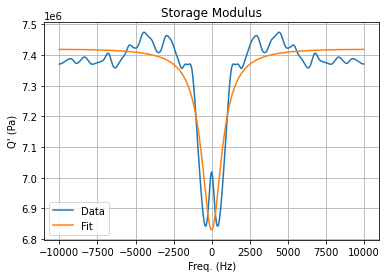

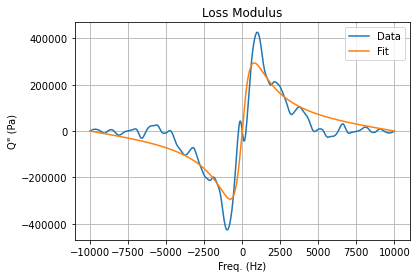

In [36]:
plot_re_im(qz, w, fit=q_fit_z)

As you can see, it is practically identical to the modified Fourier behavior; however, to be precise in presenting data acquired from the MDFT method, one should be clear that it does not exactly provide the storage and loss moduli.